In [1]:
import math
import time
import itertools
import functools
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import tqdm
import seaborn as sns

# local files
from yznets import *


In [2]:
TENSORDTYPE = torch.float64
DEVICE = 'cpu'
LOGROOTDIR = './outputs'

All problem-specific functions accpet tensor arguments.

Take $f(t,x,a)$ as an example. We assume its inputs $t, x$ and $a$ are tensors with at least 1 dimension. All dimensions except the last are regarded as batch dimensions and are equivalent in function bodies. The outputs follow this rule too. This means even the time input $t$ and the value $f(t,x,a)$ are both scalar in their definition, we force them to be tensors in shape (1,) too.

We also adopt the sequence-first convention, which is standard in seq2seq training. Most Tensors have shape (T, M, D), where

- T : time axis
- M : batch axis
- D : original dim of this quantity

# Helper Function

In [3]:
def re_cumsum(t, dim):
    r'''torch.cumsum in reverse direction'''
    return t + torch.sum(t, dim, keepdim=True) - torch.cumsum(t, dim)

In [4]:
def format_uncertainty(value, error, sig_fig=2):
    if error <= 0 or error >= value: return f"{value:.2G} ± {error:.2G}"
    digits = -math.floor(math.log10(error)) + sig_fig - 1
    if digits < sig_fig: return f"{value:.2G} ± {error:.2G}"
    return "{0:.{2}f}({1:.0f})".format(value, error*10**digits, digits)

In [5]:
def time_dir():
    return time.strftime("%y%m%d-%H%M", time.localtime())

# Problem

Solve the fully coupled FBSDE
\begin{equation*}
\left\{
\begin{aligned}
  X_t &= x_0 + \int_0^tb(s,X_s,Y_s,Z_s)\,ds + \int_0^t\sigma(s,X_s,Y_s,Z_s)\,dW_s,\\
  Y_t &= g(X_T) + \int_t^Tf(s,X_s,Y_s,Z_s)\,ds - \int_t^TZ_s\,dW_s.
\end{aligned}
\right.
\end{equation*}
Here, $X, Y, Z$ value in $\mathbb{R}^n, \mathbb{R}^m,\mathbb{R}^{m\times d}$.

# FBSDE

In [6]:
class FBSDE_LongSin(object):
    
    def __init__(self, n=4):
        self.H = 50
        self.T = 1.0
        self.n = n
        self.m = 1
        self.d = self.n
        
        self.r = 0.
        self.sigma_0 = 0.4
        
        self.x0 = .5*np.pi*torch.ones(self.n).to(device=DEVICE, dtype=TENSORDTYPE)
        
    @property
    def dt(self):
        return self.T/self.H
        
    def b(self, t, x, y, z):
        return 0.*x
    
    def sigma(self, t, x, y, z):
        return self.sigma_0 * y.unsqueeze(-1) * torch.eye(self.d).to(device=DEVICE, dtype=TENSORDTYPE)
    
    def f(self, t, x, y, z):
        return -self.r*y + .5*torch.exp(-3*self.r*(self.dt*self.H-t))*self.sigma_0**2*(10/self.n*torch.sum(torch.sin(x), dim=-1, keepdim=True))**3
    
    def g(self, x):
        return 10/self.n*torch.sum(torch.sin(x), dim=-1, keepdim=True)
    
    def get_Y(self, t, x):
        return 10/self.n*torch.exp(-self.r*(self.dt*self.H-t))*torch.sum(torch.sin(x), dim=-1, keepdim=True)
    
    def get_Z(self, t, x):
        return self.sigma_0*100/self.n**2*(torch.exp(-2*self.r*(self.dt*self.H-t))*torch.sum(torch.sin(x), dim=-1, keepdim=True)*torch.cos(x)).unsqueeze(-2)

# Solver

In [7]:
class FBSDE_BMLSolver(object):

    def __init__(self, fbsde, dirac=False):
        self.hidden_size = min(64, 1<<math.ceil(math.log2(fbsde.n+10)))
        self.batch_size = 512
        
        self.fbsde = fbsde
        self.ynet = YNet_FC3L(self.fbsde.n, self.fbsde.m, hidden_size=self.hidden_size).to(dtype=TENSORDTYPE, device=DEVICE)
        self.znet = ZNet_FC3L(self.fbsde.n, self.fbsde.m, self.fbsde.d, hidden_size=self.hidden_size).to(dtype=TENSORDTYPE, device=DEVICE)
        
        self.track_X_grad = False
        self.dirac = dirac
        self.y_lr = 5e-3
        self.z_lr = 5e-3
        
    def set_parameter(self, name, value):
        if hasattr(self, name):
            setattr(self, name, value)
        elif hasattr(self.fbsde, name):
            setattr(self.fbsde, name, value)
        else:
            raise ValueError(f"{name} is not a proper parameter")
        
    def get_optimizer(self):
        return torch.optim.Adam([
            {'params': self.ynet.parameters(), 'lr': self.y_lr,},
            {'params': self.znet.parameters(), 'lr': self.z_lr,}
        ])
        
    def obtain_XYZ(self, t=None, dW=None):
        if t is None:
            t = torch.tensor([self.fbsde.dt*i for i in range(1+self.fbsde.H)], dtype=TENSORDTYPE, device=DEVICE).reshape(-1,1,1).expand(-1, self.batch_size, 1)
        
        if dW is None:
            dW = torch.normal(0., np.sqrt(self.fbsde.dt), size=(self.fbsde.H, self.batch_size, self.fbsde.d), dtype=TENSORDTYPE, device=DEVICE)
        
        X = torch.empty(1+self.fbsde.H, dW.shape[1], self.fbsde.n, dtype=TENSORDTYPE, device=DEVICE)
        Y = torch.empty(1+self.fbsde.H, dW.shape[1], self.fbsde.m, dtype=TENSORDTYPE, device=DEVICE)
        Z = torch.empty(1+self.fbsde.H, dW.shape[1], self.fbsde.m, self.fbsde.d, dtype=TENSORDTYPE, device=DEVICE)
        
        X[0] = self.fbsde.x0
        Y[0] = self.ynet(t[0], X[0])
        Z[0] = self.znet(t[0], X[0])
        for i in range(self.fbsde.H):
            if self.track_X_grad is True:
                X[i+1] = X[i] + self.fbsde.dt * self.fbsde.b(t[i], X[i], Y[i], Z[i]) + (self.fbsde.sigma(t[i], X[i], Y[i], Z[i]) @ dW[i].unsqueeze(-1)).squeeze(-1)
            else:
                with torch.no_grad():
                    X[i+1] = X[i] + self.fbsde.dt * self.fbsde.b(t[i], X[i], Y[i], Z[i]) + (self.fbsde.sigma(t[i], X[i], Y[i], Z[i]) @ dW[i].unsqueeze(-1)).squeeze(-1)
            Y[i+1] = self.ynet(t[i+1], X[i+1])
            Z[i+1] = self.znet(t[i+1], X[i+1])
        
        return t, X, Y, Z, dW
    
    def calc_loss(self, *, dirac=None, txyzw=None):   
        t, X, Y, Z, dW = self.obtain_XYZ() if txyzw is None else txyzw
        dirac = self.dirac if dirac is None else dirac
        
        if dirac is True:
            error = Y[0] - (self.fbsde.g(X[-1]) + self.fbsde.dt * torch.sum(self.fbsde.f(t[:-1], X[:-1], Y[:-1], Z[:-1]), dim=0) - torch.sum(Z[:-1] @ dW.unsqueeze(-1), dim=0).squeeze(-1))
            return torch.sum(error*error/dW.shape[1])
        else:
            error = Y[:-1] - (self.fbsde.g(X[-1:]) + self.fbsde.dt * re_cumsum(self.fbsde.f(t[:-1], X[:-1], Y[:-1], Z[:-1]), dim=0) - re_cumsum(Z[:-1] @ dW.unsqueeze(-1), dim=0).squeeze(-1))
            if dirac is False:
                return (error*error).mean()
            elif isinstance(dirac, float):
               # weight = torch.exp(-dirac*t[:-1]/self.fbsde.dt)*(1-np.exp(-dirac))/(1-np.exp(-dirac*t.shape[0]))
                return torch.sum(error/ dW.shape[1] * error * self._get_weight(dirac, t.shape[0]-1).view(*([-1] + [1]*(len(t.shape)-1))))
            else:
                raise ValueError(f"Unknown dirac value={dirac}")
         
    @functools.lru_cache(maxsize=None)
    def _get_weight(self, gamma, N):
        return (1-np.exp(-gamma))/(1-np.exp(-gamma*N))*torch.exp(-gamma*torch.arange(N)).to(dtype=TENSORDTYPE, device=DEVICE)
    
    def calc_metric_y0(self):
        r'''assume initial time is 0.'''
        t0 = torch.zeros(1, 1, 1).to(dtype=TENSORDTYPE, device=DEVICE)
        x0 = self.fbsde.x0.view(1, 1, -1)
        pred_y0 = self.ynet(t0, x0).flatten()[0].item()
        true_y0 = self.fbsde.get_Y(t0, x0).flatten()[0].item()
        return pred_y0, abs(pred_y0/true_y0 -1.)*100
    
    def calc_metric_z0(self):
        r'''assume initial time is 0.'''
        t0 = torch.zeros(1, 1, 1).to(dtype=TENSORDTYPE, device=DEVICE)
        x0 = self.fbsde.x0.view(1, 1, -1)
        pred_z0 = self.znet(t0, x0).flatten()[0].item()
        true_z0 = self.fbsde.get_Z(t0, x0).flatten()[0].item()
        return pred_z0, abs(pred_z0/true_z0 - 1.)*100

# Benchmark of Func calc_loss

In [8]:
test_solver = FBSDE_BMLSolver(FBSDE_LongSin(n=4))
with torch.no_grad():
    t, X, Y, Z, dW = test_solver.obtain_XYZ()
    
test_solver.set_parameter('sigma_0', 0.4)
test_solver.set_parameter('r', .0)
test_solver.set_parameter('H', 50)

terminal_error = test_solver.fbsde.g(X[-1]).squeeze() - X[-1].sin().sum(dim=-1)*10/test_solver.fbsde.d
running_error = test_solver.fbsde.f(t[:-1], X[:-1], Y[:-1], Z[:-1]) - (-test_solver.fbsde.r*Y[:-1]+.5*torch.exp(-3*test_solver.fbsde.r*(test_solver.fbsde.dt*test_solver.fbsde.H-t[:-1]))*test_solver.fbsde.sigma_0**2*(X[:-1].sin().sum(dim=-1, keepdim=True)*10/test_solver.fbsde.d)**3)
martingale_error = (Z[:-1] @ dW.unsqueeze(-1)).squeeze() - torch.sum(Z[:-1].squeeze(-2)*dW,dim=-1)

assert terminal_error.abs().max() < 1e-12
assert running_error.abs().max() < 1e-12
assert martingale_error.abs().max() < 1e-12

# Loss of True Solutions

In [9]:
optimal_solver = FBSDE_BMLSolver(FBSDE_LongSin(n=4))
optimal_solver.ynet = optimal_solver.fbsde.get_Y
optimal_solver.znet = optimal_solver.fbsde.get_Z

optimal_solver.set_parameter('sigma_0', 0.4)
optimal_solver.set_parameter('r', .0)
optimal_solver.set_parameter('H', 50)

dirac_loss, lambd_loss, gamma_loss = [], [], []
for _ in tqdm.trange(10):
    t, X, Y, Z, dW = optimal_solver.obtain_XYZ()
    dirac_loss.append(optimal_solver.calc_loss(dirac=True, txyzw=(t, X, Y, Z, dW)).item())
    lambd_loss.append(optimal_solver.calc_loss(dirac=False, txyzw=(t, X, Y, Z, dW)).item())
    gamma_loss.append(optimal_solver.calc_loss(dirac=0.05, txyzw=(t, X, Y, Z, dW)).item())

print("δ-BML: ", format_uncertainty(np.mean(dirac_loss), np.std(dirac_loss)))
print("μ-BML: ", format_uncertainty(np.mean(lambd_loss), np.std(lambd_loss)))
print("γ-BML: ", format_uncertainty(np.mean(gamma_loss), np.std(gamma_loss)))

100%|██████████| 10/10 [00:00<00:00, 51.21it/s]

δ-BML:  3.82(22)
μ-BML:  0.559(50)
γ-BML:  1.026(71)


# Train

In [10]:
def solve_LongSin(n, *, repeat=10, max_steps=2000, **solver_kws):
    tab_logs, fig_logs = [], []
    for epi in range(repeat):
        _solver = FBSDE_BMLSolver(FBSDE_LongSin(n=n))
        
        for k in solver_kws:
            _solver.set_parameter(k, solver_kws[k])
        
        optimizer = _solver.get_optimizer()
        
        _solver.ynet.train()
        _solver.znet.train()
        optimizer.zero_grad()
        
        pbar = tqdm.trange(max_steps, leave=(epi==repeat-1))
        pbar.set_description(f"REP: [{epi+1}/{repeat}]")
        for step in pbar:
            loss = _solver.calc_loss()
            
            fig_logs.append({
                'epi': epi,
                'step': step,
                'loss': loss.item(),
            })
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        _solver.ynet.eval()
        _solver.znet.eval()
        _solver.batch_size = 512
        with torch.no_grad():
            pred_y0, relative_error_y0 = _solver.calc_metric_y0()
            pred_z0, relative_error_z0 = _solver.calc_metric_z0()
        
        tab_logs.append({
            'epi': epi,
            'Y0': pred_y0,
            'Err Y0': relative_error_y0,
            'Z0': pred_z0,
            'Err Z0': relative_error_z0,
        })

    return tab_logs, fig_logs

## Search Hyperparameters

In [11]:
log_dir = os.path.join(LOGROOTDIR, time_dir())
os.makedirs(log_dir, exist_ok=False)

os.makedirs(os.path.join(log_dir, "tab_logs"))
os.makedirs(os.path.join(log_dir, "fig_logs"))
os.makedirs(os.path.join(log_dir, "args_df"))

In [12]:
STATEDIM = 4
REPEATNUM = 2          # number of repeating an experiment
MAXSTEPS = 200        # max gradient steps

search_mesh = {
    'dirac': [False, True, 0.05], #, True],
    'y_lr': [5e-2], #, 5e-4, 5e-5],
    'z_lr': [5e-2],
    'batch_size': [512], #, 1024],

    'r': [0.],
    'sigma_0': [0.4],
    'H': [50],
}

args_set = list(itertools.product(*search_mesh.values()))
for i, args in enumerate(args_set):
    args = dict(zip(search_mesh.keys(), args))
    if abs(np.log10(args['y_lr']/args['z_lr'])) > 1.9:
        continue
    
    print(f"EXP: [{i+1}/{len(args_set)}]")
    tab_logs, fig_logs = solve_LongSin(n=STATEDIM, repeat=REPEATNUM, max_steps=MAXSTEPS, **args)

    args_df = pd.DataFrame(tab_logs).drop(columns=['epi']).agg(lambda arr: format_uncertainty(np.mean(arr), np.std(arr))).to_frame().T

    pd.DataFrame(fig_logs).to_csv(os.path.join(log_dir, "fig_logs", f"{i}.csv"), index=False)
    pd.DataFrame(tab_logs).to_csv(os.path.join(log_dir, "tab_logs", f"{i}.csv"), index=False)
    pd.concat([pd.DataFrame([args]), args_df], axis=1).to_csv(os.path.join(log_dir, "args_df", f"{i}.csv"), index=False)

EXP: [1/3]


REP: [2/2]: 100%|██████████| 200/200 [00:09<00:00, 21.89it/s]


EXP: [2/3]


REP: [2/2]: 100%|██████████| 200/200 [00:09<00:00, 21.61it/s]


EXP: [3/3]


REP: [2/2]: 100%|██████████| 200/200 [00:09<00:00, 21.33it/s]


## Result Analysis

In [13]:
args_df = [pd.read_csv(os.path.join(log_dir, "args_df", f"{i}.csv")) for i in range(len(args_set))]
args_df = pd.concat(args_df, keys=range(len(args_set)), names=['args']).reset_index(level='args')
args_df.to_csv(os.path.join(log_dir, "args_df.csv"), index=False)
print(pd.DataFrame(args_df).reset_index())

   index  args  dirac  y_lr  z_lr  batch_size    r  sigma_0   H          Y0  \
0      0     0  False  0.05  0.05         512  0.0      0.4  50  10.531(26)   
1      0     1   True  0.05  0.05         512  0.0      0.4  50   8.425(31)   
2      0     2   0.05  0.05  0.05         512  0.0      0.4  50   10.64(11)   

      Err Y0            Z0             Err Z0  
0   5.31(26)  -0.23 ± 0.58  9.4E+16 ± 3.8E+16  
1  15.75(31)    -1.6 ± 1.3  2.6E+17 ± 2.1E+17  
2  6.4 ± 1.1     0.638(65)    1E+17 ± 1.1E+16  


In [14]:
fig_logs = [pd.read_csv(os.path.join(log_dir, "fig_logs", f"{i}.csv")) for i in range(len(args_set))]
fig_logs = pd.concat(fig_logs, keys=range(len(args_set)), names=['args']).reset_index(level='args')

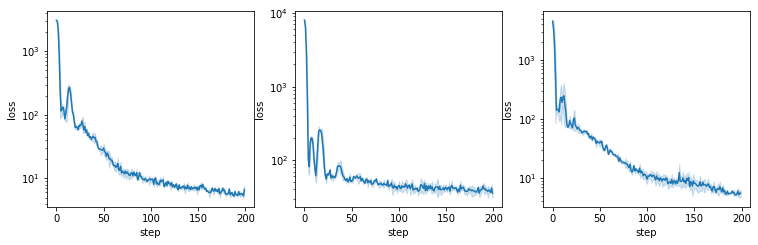

In [15]:
r_figs = 3
c_figs = math.ceil(len(args_set)/r_figs)
fig, axes = plt.subplots(c_figs, r_figs, figsize=(4.2*r_figs, 3.6*c_figs))
if c_figs == 1:
    axes = axes.reshape(1, -1)

fig_logs_gb = fig_logs.groupby('args')

for i, j in itertools.product(range(c_figs), range(r_figs)):
    if  i*r_figs + j >= len(args_set):
        break
    sns.lineplot(data=fig_logs_gb.get_group(i*r_figs+j), x='step', y='loss', ax=axes[i,j], errorbar=('ci', 68))
    axes[i,j].set_yscale('log')

In [16]:
fig.savefig(os.path.join(log_dir, "fig.pdf"))
print(f"fig.pdf saved to {log_dir}")

fig.pdf saved to ./outputs/230317-1020


In [17]:
print(f"Finished at {time_dir()}")

Finished at 230317-1021
